## Extract and match features

- Features are SIFT descriptors
- Flann matcher is used to find matches
    - Flann is trained for template image only and afterwards repeatedly used
    - Low ratio test is used to filter good matches [SIFT paper - Low ratio 0.8](http://www.cs.jhu.edu/~hager/teaching/cs461/LoweIJCV.pdf)

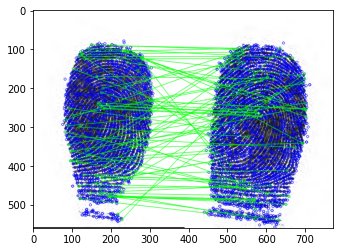

In [1]:
import cv2
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [9.5, 4]
img_src = cv2.imread("/home/psvoboda/remotes/gauss/srv/datasets/fingertips/3_modal_202003/3581/LEFT_MIDDLE.png", cv2.IMREAD_COLOR)
img_tm = cv2.imread("/home/psvoboda/remotes/gauss/srv/datasets/fingertips/3_modal_202003/36353/LEFT_MIDDLE.png", cv2.IMREAD_COLOR)

# Min Hessian whot is the minimum output of Hessian detector
# Hessian is 2nd image derivative - ie. corner/edge detection
min_hessian = 400
sift_detector = cv2.SIFT_create()
kps_tm, dsc_tm = sift_detector.detectAndCompute(img_tm, mask=None)
kps_src, dsc_src = sift_detector.detectAndCompute(img_src, mask=None)

# FLANN algorithms
#https://github.com/opencv/opencv/blob/e593d5bbc5d1b2f7e77fbe20b61f73b37b532093/modules/flann/include/opencv2/flann/defines.h#L68
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Train the Flann on a template image once only
flann = cv2.FlannBasedMatcher(index_params,search_params)
flann.add([dsc_tm])
flann.train()

matches = flann.knnMatch(dsc_src, k=2)

matchesMask = [[0,0] for i in range(len(matches))]
good_matches = []

for i,(first,second) in enumerate(matches):
    if first.distance < 0.8*second.distance:
        matchesMask[i]=[1,0]
        good_matches.append(first)
draw_params = dict(
    matchColor = (0,255,0), singlePointColor = (255,0,0),
    matchesMask = matchesMask, flags = 0)

img3 = cv2.drawMatchesKnn(
    img_src, kps_src, img_tm, kps_tm, matches, None,**draw_params)

plt.figure()
plt.imshow(img3[...,[2,1,0]],)

## Estimate the homography

- draw all homography model based matches

Text(0.5, 1.0, 'Ransac matches')

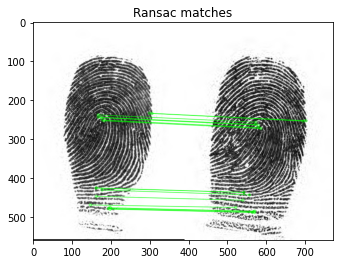

In [2]:
import numpy as np

MIN_MATCH_COUNT = 10
if len(good_matches) > MIN_MATCH_COUNT:
  pts = [(kps_src[match.queryIdx].pt, kps_tm[match.trainIdx].pt)
         for match in good_matches]

  src, dst = zip(*pts)
  pts_src = np.asarray(src, dtype=np.float32).reshape(-1, 1, 2)
  pts_dst = np.asarray(dst, dtype=np.float32).reshape(-1, 1, 2)

  mat, mask = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)
  matches_mask = mask.ravel().tolist()

  h, w = img_src.shape[:2]
    
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),MIN_MATCH_COUNT))
    matches_mask = None
    
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matches_mask, # draw only inliers
                   flags = 2)

img_matches = cv2.drawMatches(img_src, kps_src, img_tm, kps_tm, good_matches, None, **draw_params)

plt.figure()
plt.imshow(img_matches[...,[2,1,0]])
plt.title("Ransac matches")

## Apply warpPerspective with estimated Homography

Text(0.5, 1.0, 'Template image')

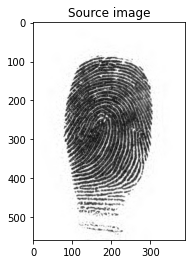

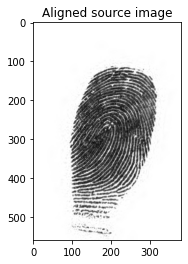

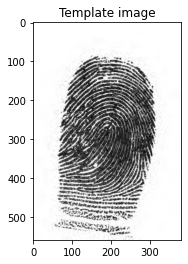

In [3]:
h, w = img_tm.shape[:2]
img_warp = cv2.warpPerspective(img_src, mat, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))

plt.figure()
plt.imshow(img_src[...,[2,1,0]])
plt.title("Source image")

plt.figure()
plt.imshow(img_warp[...,[2,1,0]])
plt.title("Aligned source image")

plt.figure()
plt.imshow(img_tm[...,[2,1,0]])
plt.title("Template image")

## Blend the aligned source image with the template image

Text(0.5, 1.0, 'Blend 0.2 Template image with 0.8 aligned source image')

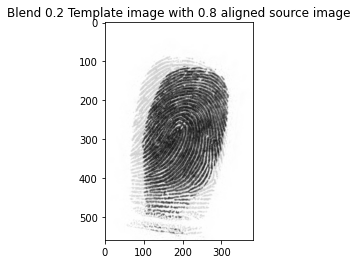

In [4]:
alpha = 0.2
blend = cv2.addWeighted(img_tm, alpha, img_warp, 1-alpha, 0.0)

plt.figure()
plt.imshow(blend[...,[2,1,0]])
plt.title("Blend {} Template image with {} aligned source image".format(alpha, 1-alpha))